# Pilot 2: An analysis of AI in health

This pilot for the RWJF project sets out to identify AI innovations which could be of interest for the RWJF.

We use a combined dataset including:

* GDB, the grant database we are working on for pilot 1 including data from:
  * [Gateway to Research](http:/http://gtr.ukri.org/) a database with information about research projects funded in the UK
  * [Innovate UK](https://www.gov.uk/government/publications/innovate-uk-funded-projects)  
  * [AHRQ](https://www.ahrq.gov/), agency healthcare research and quality, a public body supporting health research in the USA
  * [H2020](https://cordis.europa.eu/home_en.html), a database with EU R&D data
  * , a startup and tech company database
  * RWJF (the Robert Woods Johnson Foundation open dataset)
  * World reporter (TODO: Discover what this is)
  
* [Crunchbase](https://www.crunchbase.com/) a database of startup activity that we recently licensed
* GitHub, an open source database. 

How do we identify ai projects in the data? We will use Clio, an information retrieval system which extracts relevant documents from a corpus of data, and a supervised approach potentially based on labelled data such as CrunchBase or Gateway to Research. Another important output of the analysis is a better understanding of the contents of the GDB, which will be relevant for pilot 1.

The activities I will follow are as usual:

1. Preamble including imports, directories, functions and classes.
2. Load data and any necessary metadata
3. Exploratory data analysis: what's in there? what are the questions about interpretation and provenance?
4. Classification: Identify AI and health projects in the data. Think about how this analysis will include the classification developed by George Richardson (to understand the domain of health where a project sits)
5. Reporting




### Imports and paths go here

In [1]:
# %load preamble.py
%matplotlib inline
#NB I open a standard set of directories

#Paths

#Get the top path
top_path = os.path.dirname(os.getcwd())

#Create the path for external data
ext_data = os.path.join(top_path,'data/external')

#Raw path (for html downloads)

raw_data = os.path.join(top_path,'data/raw')

#And external data
proc_data = os.path.join(top_path,'data/processed')

fig_path = os.path.join(top_path,'reports/figures')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [521]:
#And the model path
mod_path = os.path.join(top_path,'models/')

### Functions and classes go here

In [198]:
def flatten_list(my_list):
    '''
    Flattens a list
    '''
    
    return([x for el in my_list for x in el])

## 1. Load data

We load the data. 

**Data dictionary**



* **GH User ID**: Github User ID.
* **GDB Dataset ID**: Only for Grants DB. Shows the dataset (Grants.gov, Research.gov, AHRQ, H2020, Innovateuk, GtR, RWJF, World Explorer) of the instance.
* **Source ID**: Can be Crunchbase, GitHub or GDB
* **Start Date**: Incorporation date, project starting date or the date that a Github repo was created.
* **Status**: Only for CB and GDB source datasets. Shows if the company/funded project is active.
* **GH User Creation Date**: Only for Github. Creation date of a user's Github profile.
* **Description**: Description of a company/funded project/github repo. 
* **Funding**: Only for CB and GDB source datasets. Shows the VC investment / public funds that companies have got. 
* **Row ID**: Every row has a unique ID that corresponds to the Crunchbase ID / Funded Project ID / Github repo ID.
* **Currency**: Only for CB and GDB source datasets. Can be USD, EUR, GBP.
* **CB Category Group List**: Only for CB. Broad categories of a Crunchbase company.
* **GH User Type**: Only for Github. A user can be either a company or a user (individual person).
* **CB Number of Employees**: Only for CB. Number of individuals employeed by a company.
* **CB Category List**: Only for CB. Categories of a Crunchbase company. More granular than *CB Category Group List*
* **CB Role**: Only for CB. Shows if an organisation is a company, investor or school.
* **End Date**: Only for CB and GDB. Shows when a company closed and when a funded project finished. I would trust *Status* more for CB dataset.
* **GH Valid Description**: Only for Github. Binary column, shows if a description has five or more tokens.
* **Name**: Company name, Participant in a funded project name, github repo name.
* **administrative_area_level_1**: Only for GDB at this point. 
* **administrative_area_level_2**: Only for GDB at this point. 
* **lng**: Only for GDB and Github. Longitude.
* **lat**: Only for GDB and Github. Latitude.
* **country**: Only for GDB at this point. 

Some observations / questions: 

* Is each GitHub project assigned to an individual and company?
* Do the GitHub projects include forks?
* We currently don't know the locations of GitHub projects. It would be easy to geocode them on the lat-lon but we'll leave it for now (Kostas is working on the geocoding anyway).
* We will need to revise the Innovate UK funding data (in that database, the levels of funding allocated to a project are per organisation, not project). Need to determine what's the situation with the other sources.
* How are projects with multiple organisations geocoded (eg GTR)? Are they geocoded to the lead organisation, to the first one to be deduplicated?


In [2]:
#Here we load the data. Note that it was compressed with gzip.
data = pd.read_csv(ext_data+'/gh_cb_gdb_v1.csv', compression='gzip')

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,5,6,8,9,10,11,12,13,14,15,16,19,20,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Tidy columns (lowercases, no spaces)
data.columns = [re.sub(' ','_',x.lower()) for x in data.columns]

## 2. Explore data

Initial data exploration to answer questions such as:

1. How missing values are there in each variable
2. How do we standardise funding amounts?
3. Do we need to standardise dates? How?


In [4]:
data.head()

,unnamed:_0,gh_user_id,gdb_dataset_id,source_id,start_date,status,gh_user_creation_date,description,funding,row_id,...,cb_category_list,cb_role,end_date,gh_valid_description,name,administrative_area_level_1,administrative_area_level_2,lng,lat,country
0,0,NaN,gtr,GDB,2012-10-01 00:00:00,Closed,NaN,"Over the last fifty years, accelerators of eve...",26776,http://gtr.rcuk.ac.uk:80/gtr/api/projects/0004...,...,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom
1,1,NaN,gtr,GDB,2002-02-01 00:00:00,Closed,NaN,Abstracts are not currently available in GtR f...,187427,http://gtr.rcuk.ac.uk:80/gtr/api/projects/000C...,...,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom
2,2,NaN,gtr,GDB,1998-10-01 00:00:00,Closed,NaN,The question of how the human brain develops o...,3.00761e+06,http://gtr.rcuk.ac.uk:80/gtr/api/projects/002D...,...,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom
3,3,NaN,gtr,GDB,2012-06-30 00:00:00,Closed,NaN,T-cells are white blood cells that enable us t...,465999,http://gtr.rcuk.ac.uk:80/gtr/api/projects/0042...,...,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom
4,4,NaN,gtr,GDB,2010-09-01 00:00:00,Closed,NaN,"When excavators dug al-Bahnasa, some 200 km so...",851035,http://gtr.rcuk.ac.uk:80/gtr/api/projects/005B...,...,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom


In [5]:
#The overwhelming majority of projects come from GitHub
data.source_id.value_counts()

GitHub        5871898
Crunchbase     662315
GDB            358506
Name: source_id, dtype: int64

In [6]:
#And what about the contents of GDB?
data.gdb_dataset_id.value_counts()

rgov              155239
gtr                79427
H2020              63125
innovateuk         31987
world_reporter     15092
rwjf                7315
ahrq                6321
Name: gdb_dataset_id, dtype: int64

We need to write some documentation for each of these, using the fields in the data audits.

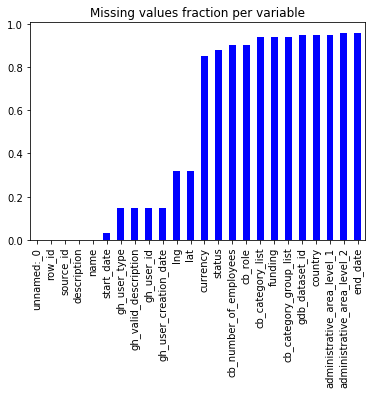

In [7]:
#What are the percentage of missing values in all the data
missing_all = (data.apply(lambda x: x.isna().sum(),axis=0)/len(data)).sort_values()

missing_all.plot.bar(color='blue',title='Missing values fraction per variable')

#We also store the order of the missing values. We will use this to sort data later
miss_vars_sorted = missing_all.index


This is not super-informative because many of the variables cover a single dataset

In [8]:
#We want to process dates (just extract the years)
#The prurpose is to look at trends and identify gaps and issues.

In [9]:
#First we need to acknowledge that each of the sources in GDB may have a different format.
#The conditional in the list comprehension avoids concatenating a missing value if the data we are considering
#is not in the GDB and therefore doesn't have a sub-source (ie grant source inside the grabt database)

data['source_detailed'] = [str(x)+'_'+str(y) if str(y)!='nan' else str(x) for x,y in zip(data['source_id'],data['gdb_dataset_id'])]

In [10]:
#This is the same as before
data['source_detailed'].value_counts()

GitHub                5871898
Crunchbase             662315
GDB_rgov               155239
GDB_gtr                 79427
GDB_H2020               63125
GDB_innovateuk          31987
GDB_world_reporter      15092
GDB_rwjf                 7315
GDB_ahrq                 6321
Name: source_detailed, dtype: int64

In [11]:
#This function gives us the fraction of missing values per data source we are considering 
missing_grouped = data.groupby('source_detailed').apply(lambda x: x.apply(lambda y: y.isna().sum()/len(y),axis=0))

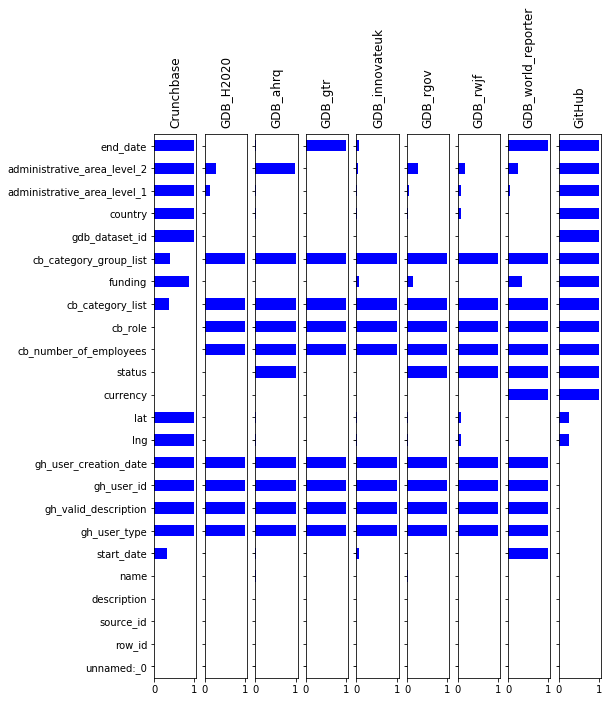

In [12]:
#Plot missing values

fig,ax = plt.subplots(ncols=len(missing_grouped),sharey=True,figsize=(8,10))

#This loops over each row in the missing grouped DF and plots missing values as a share of the total.
#We are using the missing_var_sorted to put the variables with most missing values at the top. Unexpectedly, 
#Those values which are missing from GitHub dominate

for num,x in enumerate(missing_grouped.index):
    missing_grouped.loc[x,miss_vars_sorted].plot.barh(ax=ax[num],color='blue')
    ax[num].set_title(x,rotation=90,va='bottom')

Some observations:

* Lots of CB organisations have no funding data. Are these missing values or non-company entities? We should check.
* All CBs have employees though! Or do they?
* Quite a few CB organisations have no categories (these are their 'topics' or labels)
* We have currency info for all entities with funding. It will be easy to convert them all to $
* We have start dates for almost every database except the world reporter and some innovate UK records
* Missing lat lon for almost all Crunchbase observations. How are we supposed to geocode these?

### Parse dates

In [13]:
#What are the date formats?
#We loop over each unique source and print the top 3 dates

for x in set(data['source_detailed']):
    print(x)
    print(data.loc[data['source_detailed']==x,'start_date'][:3])
    print('\n')

GDB_innovateuk
3561    2017-08-01 00:00:00
3562    2017-10-01 00:00:00
3563                    NaN
Name: start_date, dtype: object


GDB_world_reporter
343414    NaN
343415    NaN
343416    NaN
Name: start_date, dtype: object


GDB_rwjf
85764    3/25/2009
85765     3/8/2010
85766    3/18/2011
Name: start_date, dtype: object


GDB_ahrq
90822    09/30/05
90823    09/30/13
90824    09/30/13
Name: start_date, dtype: object


GDB_gtr
0    2012-10-01 00:00:00
1    2002-02-01 00:00:00
2    1998-10-01 00:00:00
Name: start_date, dtype: object


Crunchbase
358506           NaN
358507    1968-07-18
358508    1968-01-01
Name: start_date, dtype: object


GitHub
1020821    2017-08-27 17:03:00 UTC
1020822    2017-03-03 20:52:23 UTC
1020823    2017-10-01 20:06:53 UTC
Name: start_date, dtype: object


GDB_H2020
46995    2016-03-01
46996    2017-05-01
46997    2017-04-01
Name: start_date, dtype: object


GDB_rgov
91360    ="09/01/2017"
93154    ="09/01/2011"
93155    ="08/15/2010"
Name: start_date, dtyp

In [14]:
#We want to parse these to extract years. 
#A simple option is to write a function that takes two elements (the string and the source) and returns the year

def parse_string(date,datetime_function,date_format):
    '''
    This function takes a string and function, checks that the string is a string and if it is, parses it with a function and
    format.
    If it receives a timestamp style string, it splits on whitespace
    
    Otherwise it returns a np.nan
    
    '''
    
    #Check type
    if type(date)!=str:
        date_parsed = np.nan
        date_year = np.nan
    else:
        
        #Note that we are doing a bit of string cleaning to deal with some weird formats in the GDB gov data
        
        date = re.sub('=|\"','',date)
        
        #If it's a string it parses it using the function and format we provided
        #Note that the split on whitespace allows us to automatically deal with timestamps
        date_parsed = datetime_function(date.split(' ')[0],date_format)
        date_year = date_parsed.year
    
    return([date_parsed,date_year])
    


def parse_date(date,source):
    '''
    The date is a string with the date, and the source is the data source. The parsing process depends on the source.
    #The parsing function does some text processing to deal with timestamps, weird symbols in the data etc.

    '''
    
    if source in ['GDB_ahrq']:
        #Annoyingly, GDB AHRQ doesn't include full years but only the last 2 digits. 2014 is 14, 1993 is 93
        #We split on / and if the first value in the last element of the list is below 2, we concatenate with 20 otherwise 19
        if type(date)==str:
            #This gives us the last part of the date (the year)

            y = date.split('/')[-1]
            
            #Add the first two digits
            if int(y[0])<2:
                y = '20'+y
            else:
                y = '19'+y
                
            #Create a new date
            date = date[:-2]+y
                
        
        date_parsed,year = parse_string(date,datetime.datetime.strptime,'%m/%d/%Y')
    
    
    if source in ['GDB_rwjf']:
        #The year format is y/m/d.
        #Parse.
        
        date_parsed,year = parse_string(date,datetime.datetime.strptime,'%m/%d/%Y')
   
    if source in ['Crunchbase','GDB_H2020','GDB_gtr','GitHub','GDB_innovateuk','GDB_world_reporter']:
        #In these two, the year format is y-m-d or or a timestamop that is split on whitespace by the parser
        #Note that the world reporter only has missing values 
        
        date_parsed,year = parse_string(date,datetime.datetime.strptime,'%Y-%m-%d')
        
    if source in ['GDB_rgov']:
        #Here  the formart is m/d/y. The parses removes some weird symbols in the rgov data
        
        date_parsed,year = parse_string(date,datetime.datetime.strptime,'%m/%d/%Y')


    return([date_parsed,year])




In [ ]:
%%time
#Run the function
data['start_date_parsed'] = data[['start_date','source_detailed']].apply(lambda x: parse_date(x[0],x[1])[0],axis=1)
data['start_year'] = data[['start_date','source_detailed']].apply(lambda x: parse_date(x[0],x[1])[1],axis=1)


In [45]:
#All dates parsed.
year_source = pd.pivot_table(data,index='start_year',columns='source_detailed',values='row_id',aggfunc='count').fillna(0)

#So CrunchBase contains organisations started in the middle ages. fun


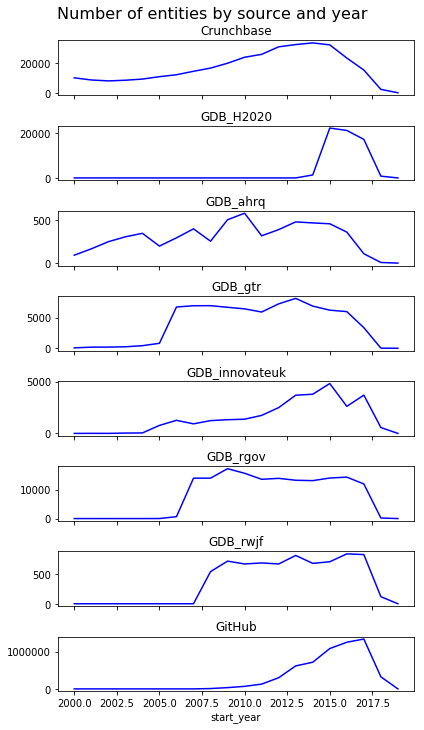

In [59]:
#Given the big differences between GitHub and other sources, we split by source when visualising trends.

#Focus on activity since 2000
year_source_recent = year_source.loc[year_source.index>1999]

#Plot
fig,ax = plt.subplots(figsize=(6,10),nrows=len(year_source.columns),sharex=True)

#We loop over columns and enumerate to identify the right ax to plot
for num,source in enumerate(year_source.columns):
    
    #Plot
    year_source_recent[source].plot(ax=ax[num],color='blue')
    
    ax[num].set_title(source)

fig.suptitle('Number of entities by source and year',size=16,y=1.01)
    
plt.tight_layout()    




This gives us a good sense of data coverage:

* Crunchbase has the smoothest trend
* H2020 starts with the most recent framework programme (last 5 years)
* GTR from around 2006 as we know
* RWJF since 2007 (is there a reason for this?)
* Innovate grows from 2005, which is somewhat odd given that they only started operation in 2007.

In [62]:
data.loc[data.source_detailed=='GDB_innovateuk'].sort_values('start_year',ascending=True).head()

,unnamed:_0,gh_user_id,gdb_dataset_id,source_id,start_date,status,gh_user_creation_date,description,funding,row_id,...,gh_valid_description,name,administrative_area_level_1,administrative_area_level_2,lng,lat,country,source_detailed,start_date_parsed,start_year
321963,321963,NaN,innovateuk,GDB,1999-04-01 00:00:00,Closed,NaN,Awaiting Public Project Summary,110220.0,210034,...,NaN,GL Industrial Services UK Limited,England,Leicestershire,-1.258469,52.760994,United Kingdom,GDB_innovateuk,1999-04-01 00:00:00,1999.0
342967,342967,NaN,innovateuk,GDB,1999-06-01 00:00:00,Closed,NaN,Awaiting Public Project Summary,652486,210001,...,NaN,Ghana Forestry Commission,England,Greater London,-0.247325,51.610680,United Kingdom,GDB_innovateuk,1999-06-01 00:00:00,1999.0
75906,75906,NaN,innovateuk,GDB,2001-04-01 00:00:00,Closed,NaN,Awaiting Public Project Summary,895759.0,210004,...,NaN,Siemens Industrial Turbomachinery Limited,England,Surrey,-0.736373,51.318211,United Kingdom,GDB_innovateuk,2001-04-01 00:00:00,2001.0
338769,338769,NaN,innovateuk,GDB,2001-10-01 00:00:00,Closed,NaN,Awaiting Public Project Summary,1.4734e+06,140080,...,NaN,card University of Cardiff,Wales,Cardiff,-3.165951,51.483818,United Kingdom,GDB_innovateuk,2001-10-01 00:00:00,2001.0
23057,23057,NaN,innovateuk,GDB,2001-09-01 00:00:00,Closed,NaN,Awaiting Public Project Summary,1.80372e+06,140077,...,NaN,University of Southampton,England,Southampton,-1.395667,50.934107,United Kingdom,GDB_innovateuk,2001-09-01 00:00:00,2001.0


There is a bunch of projects in the innovate UK data going back to 2000, and lacking a summary.

We will need to remove these projects for other analyses

### Parse currencies [TODO]

This will be relatively trivial to do using one of the currency conversion packages.

We need to decide to what currency do we convert. We also need to use the date. This will create some problems with the startup funding, where the funding was probably obtained in different periods.

In [63]:
data['currency'].value_counts()

USD    831190
GBP    111414
EUR     63125
Name: currency, dtype: int64

## 3. Classify projects

### a. Identify AI and ML projects in the data

Strategies:

* Use a model trained on GTR data to predict the probability that a project in another domain is AI/ML/Data related
* Use a model trained on CB data to predict the probability that a project in another domain is AI/ML/Data related
* Look for the presence of keywords related to AI, ML etc. (enhanced via word embeddings)

**Steps**

1. Preprocess *all* text data and explore it.
2. Train a predictive model on the CB data.
3. Load the GTR models we trained elsewhere
4. Train a w2vec model on the data and use it to find AI/ML related keywords
4. Apply the models to the whole corpus and crossvalidate performance



#### Preprocess all the data (tokenise etc) first

I will use the lda pipeline, a script I wrote before with a collection of tools for cleaning and parsing text data
It doesn't include parts of speech tagging or entity recognition

In [158]:
%run lda_pipeline.py

In [253]:
from lda_pipeline import clean_tokenise, CleanTokenize

#Modelling exports from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [241]:
#We want to convert only those entries with descriptions
#TODO: Clean this up and remove some projects with no descriptions
data_desc = data.dropna(axis=0,subset=['description']).reset_index(drop=True)

In [418]:
#We initialise a health_ct instance of the CleanTokenize class using the descriptions as input
health_ct = CleanTokenize(data_desc['description'])

#This cleans and bigrams
health_ct.clean().bigram()

In [457]:
#Turn this into a list we cxan feed to other analyses
data_tokenised = list(health_ct.tokenised)

#### i. Use predictive model we trained on the Gateway to Research

Let's see what kinds of projects are picked up by a model trained on the Gateway to Research, a database of UK research projects where some of the projects were labelled with an 'artificial intelligence' topic

In [458]:
import random

In [459]:
#We use this to load a model we trained on the GTR corpus, and a count vectoriser we used to binarise the data (into features)
with open('/Users/jmateosgarcia/links/iuk/clio_search/models/8_5_2018_ai_supervised_models.p','rb') as infile:
    ai_gtr_supervised = pickle.load(infile)


In [460]:
#Create a list with detailed sources. We will loop over this later
sources_detailed = list(set(data.source_detailed))

In [461]:
#Load the count vectoriser. Turns the data into a document term matrix with term counts, using the vocabulary from GTR.
#This will limit the relevance of these data for the wider corpus we are considering
count_vec = ai_gtr_supervised[1]

#Create the feature dataset.
X_pred = count_vec.transform(data_desc['description'])

In [462]:
#Model
best_gtr_model = ai_gtr_supervised[0][1].best_estimator_

#Make predictions
Y_pred = best_gtr_model.predict_proba(X_pred)

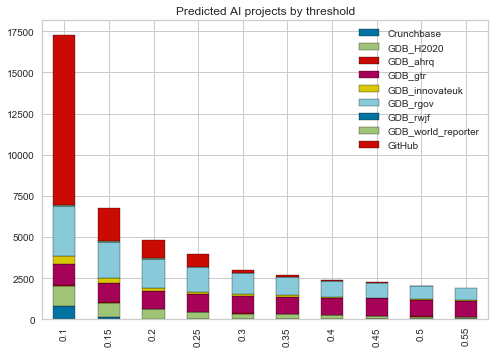

In [463]:
#What happens when we change the threshold for inclusion?
#Let's plot.

#This is a container with the source distribution of projects we predict as AI with different thresholds we use
source_by_threshold = []

for threshold in np.arange(0.1,0.6,0.05):
    #For each probability threshold we get a distribution of accepted projects over sources.
    source_distr = data_desc.loc[Y_pred[:,1]>threshold]['source_detailed'].value_counts()
    
    #We name each series with the threshold so we can later concatenate into a nicely labelled df
    source_distr.name= str(np.round(threshold,2))
    
    #Append to the container
    source_by_threshold.append(source_distr)
    
#Concatenate the series in the container
source_by_threshold_df = pd.concat(source_by_threshold,axis=1).fillna(0)

#Plot
source_by_threshold_df.T.plot.bar(stacked=True,edgecolor='black',title='Predicted AI projects by threshold')

Substantial decline in the number of predicted CrunchBase and GitHub projects when we move above a threshold of 0.1

Above 0.3 we are only picking up H2020, GTR and rgov projects

In [464]:
#Let's eyeball the results for 3 thresholds: 0.1, 0.2 and 0.5

for thres in [0.1,0.2,0.5]:
    print(thres)
    print('=====')
    
    predicted = data_desc.loc[Y_pred[:,1]>thres]
    
    #For each source we get 
    for sou in sources_detailed:
        print(sou)
        print('---')
        
        #This returns the descriptions of all projects predicted as AI/ML
        descriptions = list(predicted.loc[predicted['source_detailed']==sou,'description'])
        
        #If the length of the abstracts is below 3 there's not a lot to sample from
        if len(descriptions)<3:
            random_choice = descriptions
            
        #If there are more than 3 we get a random set of abstracts
        else:
            random_choice = random.sample(descriptions,2)
        
        #We then print them
        for x in random_choice:
            try:
                print(x[:500]) #We only print the first 500 letters
            
            #Sometimes there is nothing to print
            except:
                print('nothing')
            print('\n')
    
    print('\n')
    



0.1
=====
GDB_innovateuk
---
In late December 2014 in Edinburgh, a tragedy happened when a truck mounted the pavement before crashing into the Millennium Hotel in George Square. Unfortunately the driver of the truck had a cardiac attack prior to the accident which meant that he was unable to control the vehicle. Incidents such as this if happen in a large public transport could be catastrophic. Globalcis, believe that technology can help prevent such unfortunate happening. Globalcis is proposing inteliautodrive a seat belt 


Autonomous, or self-driving, vehicles have been hard to miss in the news recently, whether this be Tesla's partially automated 'Auto Pilot' feature, or the fully driverless 'Pods' that arrived on the streets of Milton Keynes in October 2016. As the technology becomes more familiar, people are becoming increasingly confident that individual vehicles will be able to drive and navigate themselves on roads and around people. But a single self-driving car is of limited

The lower thresholds pick up lots of noisy predictions such as projects that are just about learning. At higher threshold the projects we identify become more relevant but several datasets disappear from the data. It looks like the GTR database will, on its own, be insufficient for our analysis

#### ii. Train a predictive model on the CrunchBase data.

Now we train a predictive model on CrunchBase. Can it help us predict which projects in the rest of the data are related to AI/ML?

We need to identify labels related to AI and ML, preprocess the text to create a document term matrix and train the model


** Identify labels **

In [465]:
#This is the Crunchbase data
cb = data_desc.loc[data_desc['source_detailed']=='Crunchbase']

cb.shape

#It includes 662,209 observations

(662209, 27)

In [466]:
# Identify relevant variables
#They are the ones that have less than 100% of missing values
cb = cb[missing_grouped.T.index[missing_grouped.T['Crunchbase']<1]]

cb.head()

,unnamed:_0,source_id,start_date,status,description,funding,row_id,currency,cb_category_group_list,cb_number_of_employees,cb_category_list,cb_role,end_date,name,source_detailed
357494,0,Crunchbase,NaN,operating,Bakery,NaN,52fe377c-3dea-a49a-25e1-ba25499d1eb7,USD,Food and Beverage,unknown,Bakery,company,NaN,Vive la tarte,Crunchbase
357495,1,Crunchbase,1968-07-18,ipo,"Intel designs, manufactures, and sells integra...",2.51e+06,1e4f199c-363b-451b-a164-f94571075ee5,USD,"Design,Hardware,Manufacturing,Science and Engi...",10000+,"Hardware,Manufacturing,Product Design,Semicond...",company,NaN,Intel,Crunchbase
357496,2,Crunchbase,1968-01-01,operating,Intercomp designs and manufactures weighing an...,549000,6681b1b0-0cea-6a4a-820d-60b15793fa66,USD,"Hardware,Software",101-250,"Hardware,Software",company,NaN,Intercomp,Crunchbase
357497,3,Crunchbase,1955-01-01,ipo,Gruppo Editoriale L’Espresso is one of Italy’s...,NaN,e74463f7-94a8-ab7b-ba31-f4cd57a16570,USD,"Content and Publishing,Media and Entertainment",1001-5000,"News,Publishing",company,NaN,Gruppo Editoriale L'Espresso Spa,Crunchbase
357498,4,Crunchbase,1975-04-04,ipo,Microsoft is a software corporation that devel...,1e+06,fd80725f-53fc-7009-9878-aeecf1e9ffbb,USD,"Consumer Electronics,Hardware,Internet Service...",10000+,"Cloud Computing,Collaboration,Consumer Electro...",company,NaN,Microsoft,Crunchbase


In [467]:
#What roles are present in the data?
cb['cb_role'].value_counts()

company     613851
investor     33300
school       15058
Name: cb_role, dtype: int64

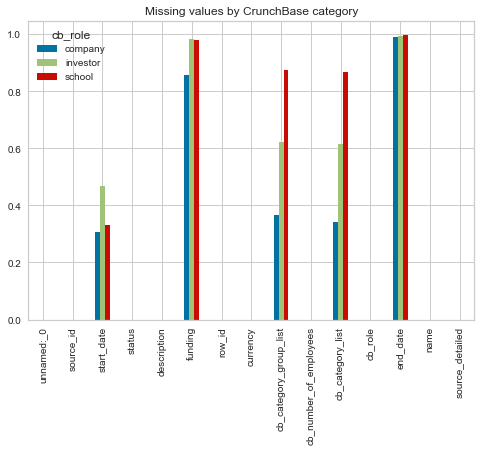

In [468]:
#Where are the missing categories?
cb.groupby('cb_role').apply(lambda x: np.sum(x.isna())/len(x)).T.plot.bar(title='Missing values by CrunchBase category')

We are interested on the sectoral info so perhaps focus on the company category where there are fewer missing values

In [469]:
#Subset to focus on companies
cb_comps = cb.loc[cb['cb_role']=='company',:]

#Turn the sectoral categories into flat lists and analyse the distribution
#NB we are avoiding the missing values at the end of the list comprehension
cat_list,cat_group_list = [flatten_list([x.split(',') for x in cb_comps[var] if type(x)==str]) for var in ['cb_category_list',
                                                                                           'cb_category_group_list']]

737


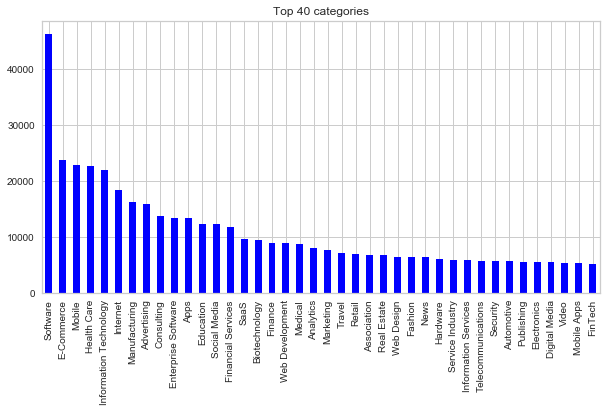

In [470]:
print(len(set(cat_list)))

pd.Series(cat_list).value_counts()[:40].plot.bar(color='blue',figsize=(10,5),title='Top 40 categories')

There are 737 CrunchBase categories. We already see an 'Analytics' one that looks interesting

46


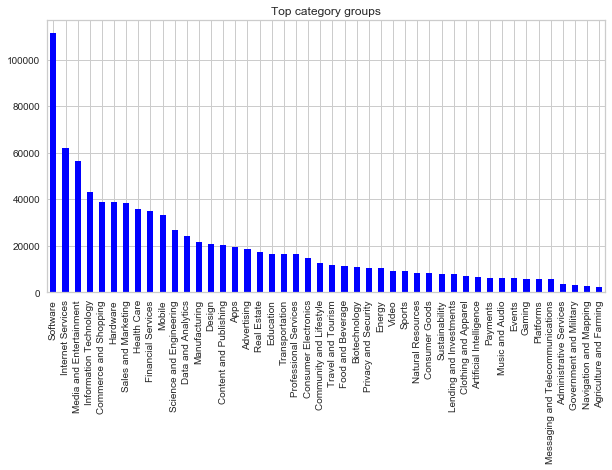

In [471]:
print(len(set(cat_group_list)))

pd.Series(cat_group_list).value_counts().plot.bar(color='blue',figsize=(10,5),title='Top category groups')

Interestingly there is an Artificial Intelligence category



In [472]:
pd.Series(cat_group_list).value_counts()['Artificial Intelligence']

The Artificial Intelligence category has 6500 observations. We can probably work with that

In [473]:
# Let's do it, to end the day.

#We simply subset a series version of the tokenised CB using the indices of the variables here. I checked and everything
#seems to line up

cb_tokenised = list(pd.Series(data_tokenised).loc[cb_comps.index])

#We turn each tokenised element into a string for the count vectorisation.
#TODO: Make this less roundabout
cb_tokenised_string = [' '.join(x) for x in cb_tokenised]

In [474]:
#Initialise the count vectoriser and fit it to the CB data

#Initialise and fit
count_vec_cb = CountVectorizer(stop_words='english',min_df=5).fit(cb_tokenised_string)

#Generate the X
X = count_vec_cb.transform(cb_tokenised_string)

In [475]:
#Also need to generate the target
Y = ['Artificial Intelligence' in categories if type(categories)!=float else 0 for categories in cb_comps['cb_category_group_list']]

In [476]:
#Do some grid search with a pair of models

#Each element in this list is a classifier and some parameters to use in grid search

models_params = [
    [RandomForestClassifier(),
     {'class_weight':['balanced',None],'min_samples_leaf':[1,5]}],
    
    [LogisticRegression(),
     {'class_weight':['balanced',None],'penalty':['l1','l2'],
      'C':[0.1,1,100]}]]
                    
#Container
cb_results = []

#For each model, run the analysis.
for num,mod in enumerate(models_params):
    print(num)
    
    #Initialise the Grid Search classifier with the combination of parameters
    clf = GridSearchCV(mod[0],mod[1])
    
    #Fit
    clf.fit(X,Y)
    
    #Append results
    cb_results.append(clf)

0
1


In [477]:
cb_mod = cb_results[1]
Y_pred = cb_mod.best_estimator_.predict_proba(X)

In [478]:
pd.crosstab(pd.Series(Y),pd.Series(Y_pred[:,1]>0.5))

col_0,False,True
row_0,,
False,606807,631
True,5620,793


This doesn't work very well. Low recall (less than 10% and low precision (just over 50%)

In [479]:
#Let's test results

#False positives
ai_fp = pd.Series(Y)==False & pd.Series(Y_pred[:,1]>0.5)

#False negatives
ai_fn = pd.Series(Y)==True & pd.Series(Y_pred[:,1]<0.5)

#True positives
ai_tp = pd.Series(Y)==True & pd.Series(Y_pred[:,1]>0.5)

cb_comps_2 = cb_comps.reset_index(drop=True)


In [487]:
test = [[name,random.sample(list(cb_comps_2.loc[comps,'description']),10)] for name,comps in zip(
    ['false positive','false negative','true positive'],[ai_fp,ai_fn,ai_tp])]


for x in test:
    print(x[0])
    print('=====')
    
    for entry in x[1]:
        print('\t'+entry)
        print('\n')
    print('\n')

false positive
=====
	Humanoid Events is a conference all about humanoid robots.


	Archon is a company based in Italy and USA, specialized in providing automated operations with UAVs and rovers in energy installations.


	Our factory in China specializes in the design and manufacture of all kinds of bedding products.


	PEAK Group is a substantial player in the service sector and provides array of Agency, Representation and Consultancy services.


	Innovum provides technology solutions for the management and development of people and their employability.


	SnapMD operates a cloud-based patient-to-provider telemedicine platform that connects individuals with pediatric physicians in the U.S.


	Get quality materials for your studies


	PlanetGR is an online social networking service and platform for Greeks.


	Council Global the first pure #IoT consultancy is open for business.


	King of Condos is a luxury real estate broker that focuses on the sale of luxury condos in vacation destin

It looks like CrunchBase will be useless as a labelled dataset. Descriptions are too short and it's unclear how they link with the AI label

#### iii. Use a keyword based strategy

The third strategy is to look for relevant keywords in the data. The challenge we face is identifying the right set of keywords. This is what we will do through Clio. As a placeholder, we simply identify some keywords through word2vec. Would it make sense to look for them separately by dataset and then create a combined set of relevant keywords?


In [481]:
w2v = models.Word2Vec(data_tokenised)

In [519]:
w2v.most_similar('machine_learning')

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('data_mining', 0.8067034482955933),
 ('ml', 0.8028653860092163),
 ('deep_learning', 0.78989577293396),
 ('artificial_intelligence', 0.7642579078674316),
 ('nlp', 0.7451745867729187),
 ('computer_vision', 0.7415744066238403),
 ('supervised_learning', 0.7270875573158264),
 ('ai', 0.7105552554130554),
 ('machine-learning', 0.7100757360458374),
 ('text_classification', 0.6986529231071472)]

This is replaced with a clio powered analysis.

### b. Generate richer health categories

Some of our datasets contain rich descriptions of activities in the health domain which we could use to try to understand the meaning or purpose of health activities in the data. For example:

* The Gateway to Research contains information about disease areas and health topics which we could use to generate predictions about the rest of the data.
* The RWJF data contains information about programme areas they work in.

In this section we will load models that we trained in **`notebook 2`** and use them to generate predictions about the rest of the GDB data.


In [551]:
#We write a function that we will use with the two sets of models we wrote before

def transfer_predictions(model_pack,corpus):
    '''
    This function takes a 'model pack' we have trained elsewhere: count vectoriser, model and variable names.
    
    It transforms the corpus into a set of features and predicts labels
    
    '''
    
    # Create features
    
    #We load the count vectoriser we trained on the GTR data
    count_vec = model_pack[0]

    #Estimator
    estimator = model_pack[1]

    #Var names
    class_names = model_pack[2]
    
    
    #Use it to create a feature set based on the merged dataset
    X_for_pred = count_vec.transform(corpus)
    
    #Generate predictions
    output = pd.DataFrame(estimator.predict_proba(X_for_pred),columns=class_names)
    
    #Return
    return(output)


def report_findings
    

#### i. With the Gateway to Research models

In [552]:
#Load model
with open(mod_path+'15_5_2018_gtr_disease_models.p'.format(date=today_str),'rb') as infile:
    gtr_models = pickle.load(infile)

gtr_preds = transfer_predictions(gtr_models,data_desc['description'])


In [599]:
#We have outputed probabilities. We focus on projects with high confidence (>0.7). 
#We make other values np.nan to facilitate classification through idxmax later.

gtr_high_conf = gtr_preds.applymap(lambda x: np.nan if x<0.9 else x)

#### ii. With the RWJF models

In [554]:
#Load model
with open(mod_path+'15_5_2018_rwj_topics.p'.format(date=today_str),'rb') as infile:
    rwj_models = pickle.load(infile)

rwj_preds = transfer_predictions(rwj_models,data_desc['description'])

In [569]:
#Same as with GTR
rwj_high_conf = rwj_preds.applymap(lambda x: np.nan if x<0.9 else x)

#### iv. Classify





In [600]:
#Each project is allocated to its top category based on the high confidence scores form GTR and RWJ
data_desc['dis_pred'],data_desc['rwj_pred'] = [var.idxmax(axis=1) for var in [gtr_high_conf,rwj_high_conf]]

In [602]:
#And now we want to check the outputs

def check_outputs(df,group_var,check_var,descr_var,condition,sample_n=3,length=500):
    '''
    
    This simple function takes a df and returns a sample of records in the check_var (if they fulfill the condition)
    grouped by the source var. This helps us assess the 
    
    '''
    #Subsets a df by the condition
    relevant = df.loc[df[check_var]==condition,:]
    
    #Groups the df by the category and obtain the descriotions 
    descriptions_by_cat = relevant.groupby(group_var)[descr_var].apply(lambda x: list(x))
        
    for x in descriptions_by_cat.index:
    
        print(x)
        print('===')
        
        random_selection = random.sample(descriptions_by_cat[x],1)

        for des in random_selection:
            print(des[:500])
            print('\n')

        print('\n')


In [605]:
#Run bthe check_outputs function for all the categories in relevant variables
#for disease in set(data_desc['rwj_pred'].dropna()):
#    print(disease.upper())
#    check_outputs(data_desc,group_var='source_detailed',check_var='rwj_pred',descr_var='description',condition=disease)b

#### **Observations based on some eyeballing of the outputs from classification**

The results are hit and miss and depend a lot on the category we are considering and its vocabulary.

For example, topics related to Nurses, Cancer, Neurology or Obesity are relatively easy to predict: they have a unique and specific vocabulary / terminology. The situation is different with topics like 'Health Costs' or 'Environmental determinants of health'. In that case, we find that the predictive models applied outside of health pick up anything to do with cost reduction regardless of the domain. The reason for this is that we trained the model on a health database where health is not a highly predictive variable for health costs. 

One way forward is to focus the model on the analysis of projects that are identified as health with a simple binary classifier, or Clio, and then to classify projects there inside the right categories. We will try to do this below.



### d. Clio powered analysis

In parallel to the analysis above, we have used Clio to query the data and identify relevant projects. I will load the project IDs and query the data


In [609]:
# Load the pickled dicts with the data

with open(int_data+'/health_and_ai_ids.pickle','rb') as infile:
    health_ai_ids = pickle.load(infile)


In [610]:
#How many of each do we have?

print(len(health_ai_ids['AI IDs']))
print(len(health_ai_ids['Health IDs']))

128647
117285


In [612]:
#Extract the data

#We create two booleans showing where the AI projects and health projects are 
data_desc['is_ai'],data_desc['is_health'] = [data_desc['row_id'].apply(lambda x: x in health_ai_ids[id_list]) for 
                                   id_list in ['AI IDs','Health IDs']]

#And a boolean indicating health-ai projects
data_desc['ai_health'] = (data_desc['is_ai'] == True) & (data_desc['is_health']==True)



In [613]:
#This is what the health/AI matrix looks like
pd.crosstab(data_desc['is_ai'],data_desc['is_health'])


is_health,False,True
is_ai,,
False,6734395,123280
True,24998,8928


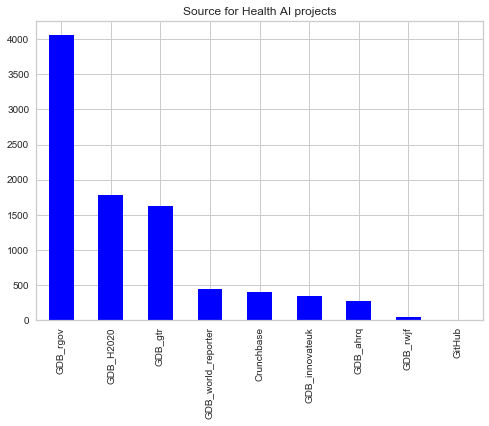

In [614]:
#here is the distribution over datasets

data_desc.loc[data['ai_health']==True,'source_detailed'].value_counts().plot.bar(color='blue',
                                                                           title='Source for Health AI projects')

Nothing from GitHub!

In [616]:
#Create a dataset focused on AI / Health
ai_h = data_desc.loc[data_desc['ai_health']==True]

#Print examples from each
#We create a list for each source
ai_descriptions = ai_h.groupby('source_detailed')['description'].apply(lambda x: list(x))

for x in ai_descriptions.index:
    
    print(x)
    print('===')
    
    random_selection = random.sample(ai_descriptions[x],3)
    
    for des in random_selection:
        print(des)
        print('\n')
        
    print('\n')
    



Crunchbase
===
Lumme uses wearable technology and machine learning to assist with smoking cessation.


InferX provides predictive analytics and business intelligence solutions for financial services, healthcare, and government enterprises.


Artificial Intelligence chatbot to improve teenager wellbeing




GDB_H2020
===
Today’s rich digital information environment is characterized by the multitude of data sources providing information that has not yet reached its full potential in eHealth. CrowdHEALTH will introduce a new paradigm of Holistic Health Records (HHRs) that include all health determinants. HHRs will be transformed into Social HHRs communities capturing the clinical, social and human context of the population segmentation and as a result the collective knowledge for different factors depending on the communities formulation criteria (e.g. demographics, diseases, lifestyle choices, nutrition, etc). CrowdHEALTH will deliver a secure integrated ICT platform that seamlessly inte

### Combine the above with our predictive analysis of disease areas and topics

Some of the questions we are interested in:

* Trends in AI for Health
* Disease area focus and RWJF topic focus



Text(0.5,0,'% of all health projects')

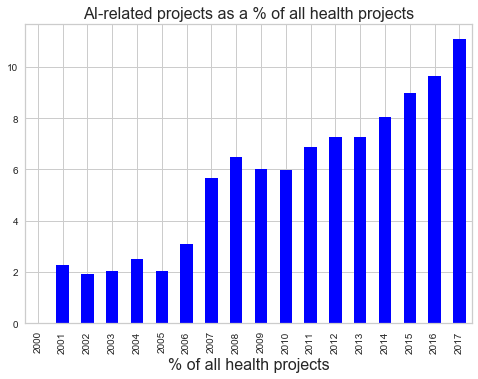

In [655]:
#Create a df with only the health projects
health = data_desc.loc[data_desc.is_health==True,:]

#Here we are plotting the share of AI projects in Health between 2000 and 2018

health_ai_year = health.groupby('start_year')['ai_health'].mean()[np.arange(2000,2018)]

#And plot
fig,ax = plt.subplots()

(100*health_ai_year.rolling(window=2).mean()).plot.bar(color='blue',ax=ax)

ax.set_title('AI-related projects as a % of all health projects',size=16)
ax.set_xlabel('% of all health projects',fontsize=16)

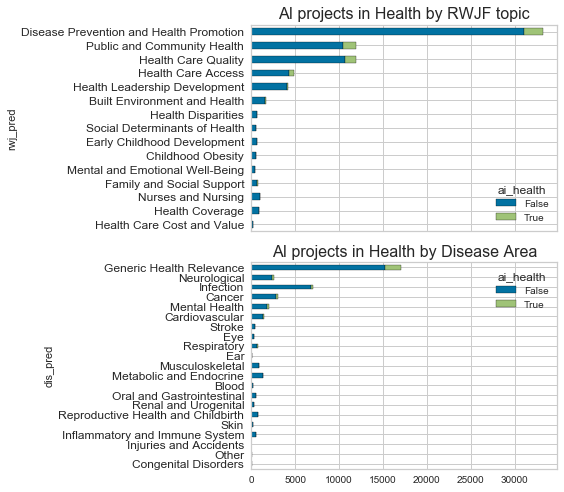

In [757]:
#AI by disease area
fig,ax = plt.subplots(nrows=2,figsize=(8,7),sharex=True)

#This looks at the number of AI/ML projects per RWJF topic
ai_rwj_topic = pd.pivot_table(
    health,index='rwj_pred',columns='ai_health',values='row_id',aggfunc='count').fillna(0)
ai_rwj_topic.sort_values(True,ascending=True).plot.barh(stacked=True,ax=ax[0],edgecolor='black')

ax[0].set_title('AI projects in Health by RWJF topic',size=16)

ax[0].axes.tick_params('y',labelsize=12)

#This looks at the same thing but by disease area
ai_dis_area = pd.pivot_table(
    health,index='dis_pred',columns='ai_health',values='row_id',aggfunc='count').fillna(0)
ai_dis_area.sort_values(True,ascending=True).plot.barh(stacked=True,ax=ax[1],edgecolor='black')

ax[1].set_title('AI projects in Health by Disease Area',size=16)

ax[1].axes.tick_params('y',labelsize=12)

plt.tight_layout()

plt.savefig(fig_path+'/{date}_areas.pdf'.format(date=today_str))


In [704]:
def gimme_examples(df,variable,value,how_many=3,length=500):
    '''
    Simple function to get some examples of AI projects
    
    '''
    
    projs = list(df.loc[(df.is_ai==True) & (df[variable]==value),'description'])
    
    examples = random.sample(projs,how_many)
    
    for x in examples:
        print(x[:length])
        print('\n')
    

In [756]:
# Some examples

gimme_examples(health,'dis_pred','Mental Health',length=1000)

The identification of cognitive impairments in early childhood provides the best opportunity for successful remedial intervention, because brain plasticity diminishes with age.  Attention deficit hyperactivity disorder (ADHD) is a psychiatric neurodevelopmental disorder that is very hard to diagnose or tell apart from other disorders.  Symptoms include inattention, hyperactivity, or acting impulsively, all of which often result in poor performance in school and persist later in life.  In this project, an interdisciplinary team of computer and neurocognitive scientists will develop and implement transformative computational approaches to evaluate the cognitive profiles of young children and to address these issues.  The project will take advantage of both physical and computer based exercises already in place in 300 schools in the United States and involving thousands of children, many of whom have been diagnosed with ADHD or other learning disabilities.  Project outcomes will have impo

In [759]:
gimme_examples(health,'rwj_pred','Health Care Access',length=1500)

Cloud computing services (such as Amazon EC2 system, Google  AppEngine, and Microsoft Azure) are becoming ubiquitous and are starting to serve as the primary source of computing power for both enterprises and personal computing applications. A cloud computing platform (or simply, a cloud) can provide a variety of resources, including infrastructure, software, and services, to users in an on-demand fashion. Compared to traditional own-and-use approaches, cloud computing services eliminate the costs of purchasing and maintaining the infrastructures for cloud users, and allow the users to dynamically scale up and down computing resources in real time based on their needs.<br/><br/>A cloud consists of a number of machines (computers), each with a certain amount of resources (CPU, RAM, hard disk space, etc.). Each machine can be subdivided into virtual machines, where each virtual machine (VM) behaves like a small machine with a certain amount of dedicated resources. When a user submits a j

In [698]:
#Examples

ai_h_dis = ai_h.groupby('dis_pred')['description'].apply(lambda x: list(x))

for dis in ai_h_dis.index:
    
    print(dis)
    print('===')
    selected = random.sample(list(ai_h_dis.loc[dis]),3)
    
    for sel in selected:
        print(sel[:1000])
        print('\n')



Blood
===
The brain, more than any other organ in the body, requires a constant supply of blood in order to maintain its function. When blood pressure drops, small arteries dilate to restore flow levels, and when pressure rises, they constrict to protect the most delicate blood vessels and avoid bleeding in the brain. This control system can however become impaired for example following stroke, head trauma, in dementia or following premature birth and this has been associated with worse outcomes for the patient. Failure of the control system also has important implications for the management of patient's blood pressure: changes in blood pressure could be dangerous without the protection of this 'autoregulatory' system.
This project aims to improve methods for measuring cerebral autoregulation and to gain a deeper understanding of the complex relationship between blood pressure and blood flow in healthy individuals and patients following stroke. While much work has been done in this fie

In [762]:
30000/(4*21)

357.14285714285717